# Library

In [38]:
import pandas as pd
import numpy as np
import os
import re
import collections
import unidecode
import nltk
from nltk.corpus import stopwords
import itertools 
from nltk.tokenize import word_tokenize
from string import punctuation
from functools import reduce
import seaborn as sns
from abbreviations import schwartz_hearst

In [39]:
pd.set_option('display.max_colwidth', 100)

In [40]:
%matplotlib inline
from matplotlib import pyplot as plt

# Functions

In [41]:
def read_texts(path):
    data = []
    file_name = os.listdir(path)

    for name in file_name:
        if name.endswith('.txt'):
            with open(path + name,encoding="utf8") as f:
                text = f.read()
                data.append({'nombre':name.replace('.txt',''), 'texto':text})

    df = pd.DataFrame(data)
    return df

In [42]:
nltk.download('stopwords')
swords = list(set(stopwords.words('spanish')))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/egarcia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
def clean_text(string):
    """
    A method to clean text 
    """
    
    # Removing the punctuations
    for x in string.lower(): 
        if x in punctuation:
            if x != '/':
                string = string.replace(x, "")
            else:
                string = string.replace(x, " ")
    
    string = unidecode.unidecode(string)

#     # Converting the text to lower
#     string = string.lower()

    # Removing stop words
    string = ' '.join([word for word in string.split() if word not in swords])

    # Cleaning the whitespaces
    string = re.sub(r'\s+', ' ', string).strip()

    return string 

In [44]:
def distance_levenshtein(str1, str2):
    d=dict()
    for i in range(len(str1)+1):
        d[i]=dict()
        d[i][0]=i
    for i in range(len(str2)+1):
        d[0][i] = i
    for i in range(1, len(str1)+1):
        for j in range(1, len(str2)+1):
            d[i][j] = min(d[i][j-1]+1, d[i-1][j]+1, d[i-1][j-1]+(not str1[i-1] == str2[j-1]))
    return d[len(str1)][len(str2)]

In [45]:
def normalize_lf(row):
    leven2 = []
    for i in row:
        for j in row:
            if i != j:
                long = max(len(i),len(j))
                ratio = distance_levenshtein(i,j)/long
                if ratio < 0.2:
                    leven2.append(j)
    if leven2:
        leven2 = set(leven2)
        lista = []
        for i in leven2:
            val = frec[frec['index'] == i]['long_form'].iloc[0]
            lista.append((i, val))
        lista = set(lista)
        most_freq = sorted(set(lista), key=lambda x: x[1], reverse = True)[0][0]
        sust = {}
        for i in set(leven2):
            sust[i] = most_freq
        
        return sust
    else:
        pass
    

In [46]:
def get_label(row):
    if row['long_form_x'] == row['long_form_y']:
        return 1
    else:
        return 0

# Load Data

### Testing

220 clinical cases.

In [52]:
testing_abbr = pd.read_csv("../../acronym_disambiguation_tfm/data/ibereval_data/testing_set/clinical_cases.abbreviations.testing_set.tsv", sep = '\t')
testing_rel = pd.read_csv("../../acronym_disambiguation_tfm/data/ibereval_data/testing_set/clinical_cases.relations.testing_set.tsv", sep = '\t')

In [53]:
testing_rel = testing_rel.reset_index()

In [54]:
testing_rel.columns = ['# Document_ID', 'Mention_A_type', 'Mention_A_StartOffset',
      'Mention_A', 'Relation_type', 'Mention_B_type',
       'Mention_B_StartOffset', 'Mention_B_EndOffset', 'Mention_B']

In [55]:
testing_rel = testing_rel.rename(columns = {'# Document_ID': 'doc_id'})

In [56]:
testing_rel.head()

,doc_id,Mention_A_type,Mention_A_StartOffset,Mention_A,Relation_type,Mention_B_type,Mention_B_StartOffset,Mention_B_EndOffset,Mention_B
0,S0211-69952013000500019-1,SHORT_FORM,3739,ARA II,SHORT-LONG,LONG_FORM,3695,3737,antagonista del receptor de angiotesina II
1,S0211-69952013000500019-1,SHORT_FORM,2793,PCR,SHORT-LONG,LONG_FORM,2798,2837,reacción en cadena de enzima polimerasa
2,S0365-66912004000600008-1,SHORT_FORM,406,AV,SHORT-LONG,LONG_FORM,390,404,agudeza visual
3,S0211-69952012000500025-1,SHORT_FORM,945,angio-TAC,SHORT-LONG,LONG_FORM,908,943,angiotomografía computarizada axial
4,S1130-05582017000200122-1,SHORT_FORM,940,RMN,SHORT-LONG,LONG_FORM,910,938,resonancia magnética nuclear


In [57]:
testing_rel.Relation_type.unique()

array(['SHORT-LONG', 'SHORT-NESTED', 'NESTED-LONG'], dtype=object)

In [58]:
testing_rel[testing_rel.Relation_type== 'NESTED-LONG'].head()

,doc_id,Mention_A_type,Mention_A_StartOffset,Mention_A,Relation_type,Mention_B_type,Mention_B_StartOffset,Mention_B_EndOffset,Mention_B
37,S0212-71992004001100007-1,NESTED,1582,Transtorácica,NESTED-LONG,LONG_FORM,1566,1581,Ecocardiografia
38,S0212-71992004001100007-1,NESTED,1604,Transesofágica,NESTED-LONG,LONG_FORM,1566,1581,Ecocardiografia
108,S1130-14732005000500006-1,NESTED,719,protrombina,NESTED-LONG,LONG_FORM,708,718,tiempos de
110,S1130-14732005000500006-1,NESTED,741,tromboplastina parcial activada,NESTED-LONG,LONG_FORM,708,718,tiempos de
134,S0365-66912007001200009-1,NESTED,269,izquierdo,NESTED-LONG,LONG_FORM,235,238,ojo


In [36]:
testing_abbr = testing_abbr.rename(columns = {'# Document_ID': 'doc_id'})

In [37]:
testing_abbr.head()

,doc_id,StartOffset,EndOffset,Abbreviation,Definition,Definition_lemmatized
0,S0212-71992005000500009-1,533,537,/mm3,milímetro cúbico,milímetro cúbico
1,S1130-14732005000200003-1,1857,1858,µ,micro,micro
2,S0211-69952013000200018-1,2512,2514,µg,microgramo,microgramo
3,S0212-16112004000400007-1,4558,4560,µg,microgramo,microgramo
4,S1137-66272014000300016-1,1112,1114,µg,microgramo,microgramo


In [59]:
testing_raw = read_texts("../../acronym_disambiguation_tfm/data/ibereval_data/testing_set/testing_set.raw_text/")

In [60]:
testing_raw.head()

,nombre,texto
0,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d..."
1,S0004-06142009000400011-1,Varón de 75 años con antecedentes de EPOC moderado sin otros antecedentes médicos de interés. En...
2,S0376-78922011000200004-1,Mujer de 44 años de edad con antecedentes médicos de insuficiencia renal crónica en tratamiento ...
3,S1137-66272014000300016-1,Mujer de 36 años sin antecedentes médicos o epidemiológicos de interés que es ingresada en la Un...
4,S1130-01082008000800019-1,"Recientemente, atendimos en nuestro hospital a un varón de 46 años, con antecedente de síndrome ..."


### Trainning

318 clinical cases

In [123]:
train_abbr = pd.read_csv("../acronym_disambiguation_tfm/data/ibereval_data/trainning_set/clinical_cases.abbreviations.training_set.tsv", sep = '\t')

In [61]:
train_met = pd.read_csv("../../acronym_disambiguation_tfm/data/ibereval_data/trainning_set/clinical_cases.metadata.training_set.tsv", sep = '\t')
train_rel = pd.read_csv("../../acronym_disambiguation_tfm/data/ibereval_data/trainning_set/clinical_cases.relations.training_set.tsv", sep = '\t')

In [125]:
train_met = train_met.rename(columns = {'# Document_ID': 'doc_id'})

In [126]:
train_met.head()

,doc_id,Case_ID,ISSN,Date,Source,Full_Text_Link
0,S1139-76322015000500009-1.txt,1.txt,1139-7632,2015-12-01,Pediatría Atención Primaria v.17 n.68 2015,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1139-76322015000500009
1,S1130-05582008000400007-2.txt,2.txt,1130-0558,2008-08-01,Revista Española de Cirugía Oral y Maxilofacial v.30 n.4 2008,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1130-05582008000400007
2,S0210-48062006000100012-1.txt,1.txt,0210-4806,2006-01-01,Actas Urológicas Españolas v.30 n.1 2006,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0210-48062006000100012
3,S0213-12852003000500002-1.txt,1.txt,0213-1285,2003-10-01,Avances en Odontoestomatología v.19 n.5 2003,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0213-12852003000500002
4,S0212-71992005000400007-1.txt,1.txt,0212-7199,2005-04-01,Anales de Medicina Interna v.22 n.4 2005,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0212-71992005000400007


In [127]:
train_rel = train_rel.reset_index()

In [128]:
train_rel.columns = ['# Document_ID', 'Mention_A_type', 'Mention_A_StartOffset',
      'Mention_A', 'Relation_type', 'Mention_B_type',
       'Mention_B_StartOffset', 'Mention_B_EndOffset', 'Mention_B']

In [129]:
train_rel = train_rel.rename(columns = {'# Document_ID': 'doc_id'})

In [130]:
train_rel.head()

,doc_id,Mention_A_type,Mention_A_StartOffset,Mention_A,Relation_type,Mention_B_type,Mention_B_StartOffset,Mention_B_EndOffset,Mention_B
0,S1130-01082009000400014-1,SHORT_FORM,476,NPT,SHORT-LONG,LONG_FORM,454.0,474.0,nutrición parenteral
1,S1130-63432016000100009-1,SHORT_FORM,614,NIHSS,SHORT-LONG,LONG_FORM,621.0,662.0,National Institute of Health Stroke Scale
2,S1139-76322017000200007-1,SHORT_FORM,1145,CMV,SHORT-LONG,LONG_FORM,1128.0,1143.0,citomegalovirus
3,S1139-76322017000200007-1,SHORT_FORM,1243,VSG,SHORT-LONG,LONG_FORM,1206.0,1241.0,velocidad de sedimentación globular
4,S1139-76322017000200007-1,SHORT_FORM,1300,IGRA,SHORT-LONG,LONG_FORM,1267.0,1298.0,interferon-gamma release assays


In [131]:
train_abbr = train_abbr.rename(columns = {'# Document_ID': 'doc_id'})

In [132]:
train_abbr.Definition.nunique()

908

In [133]:
train_abbr.head()

,doc_id,StartOffset,EndOffset,Abbreviation,Definition,Definition_lemmatized
0,S0210-48062004000500008-1,1650,1652,ml,mililitro,mililitro
1,S0210-48062004000500008-1,708,709,l,litro,litro
2,S0210-48062004000500008-1,704,707,mEq,miliequivalente,miliequivalente
3,S0210-48062004000500008-1,677,681,pCO2,presión parcial de co2,presión parcial de co2
4,S0210-48062004000500008-1,2287,2290,HLA,human leucocyte antigen,human leucocyte antiger


In [62]:
train_raw = read_texts("../../acronym_disambiguation_tfm/data/ibereval_data/trainning_set/training_set.raw_text/")

In [63]:
train_raw = train_raw.rename(columns = {'nombre': 'doc_id'})

In [64]:
train_raw.head()

,doc_id,texto
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec..."
1,S1130-01082009000300015-1,"Varón de 70 años, fumador, con enfisema pulmonar y vitíligo al que en mayo de 2001 se realizó un..."
2,S0210-56912010000200009-1,Se trata de una mujer de 70 años con antecedentes de HTA y diagnosticada recientemente de neopla...
3,S1130-01082008000900014-1,Varón de 41 años diagnosticado de adenocarcinoma medianamente diferenciado implantado sobre esóf...
4,S0210-48062004000500008-1,Paciente de 29 años de edad que acude al Servicio de Urgencias de nuestro Hospital ante la prese...


## Prepare Train Data

### Preprocessing

In [183]:
train = train_raw.merge(train_abbr[['doc_id', 'Abbreviation', 'Definition']], on = 'doc_id', how = 'left')

In [184]:
train = train.merge(train_abbr, on = ['doc_id', 'Abbreviation'], how = 'left')

In [185]:
train = train.drop_duplicates()

In [186]:
train = train[['doc_id', 'texto', 'Abbreviation', 'Definition_x', 'StartOffset', 'EndOffset']]

In [187]:
train = train.rename(columns = {'Definition_x':'Definition'})

In [188]:
train.head()

,doc_id,texto,Abbreviation,Definition,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908.0,1910.0
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684.0,1686.0
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656.0,1658.0
3,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1414.0,1416.0
12,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",g,gramo,1654.0,1655.0


In [189]:
train = train.rename(columns = {'Abbreviation': 'short_form', 'Definition': 'long_form'})

In [190]:
train = train.dropna(subset = ['short_form', 'long_form'])

In [191]:
train[['StartOffset', 'EndOffset']] = train[['StartOffset', 'EndOffset']].astype(int)

Clean long forms to delete acents, string punctuation etc

In [192]:
train['long_form'] = train['long_form'].map(clean_text)

In [193]:
train.head(3)

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908,1910
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684,1686
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656,1658


### Analysis acronyms and definitions

In [194]:
sf_lf = train[['short_form', 'long_form']].drop_duplicates()

In [198]:
#Length of the abbreviations
sf_lf['len_sf'] = sf_lf['short_form'].map(lambda x: len(x))
letters = sf_lf['len_sf'].value_counts().rename_axis('Number letters in the acronym').reset_index(name='Count')
letters.Count = letters.Count.map (lambda x: round(x,2))
letters

,Number letters in the acronym,Count
0,3,354
1,2,205
2,4,150
3,5,65
4,1,48
5,6,28
6,7,16
7,8,8
8,9,5
9,10,2


In [195]:
sf_lf.head()

,short_form,long_form
0,dl,decilitro
12,g,gramo
14,gamma-GT,gammaglutamyl transpeptidase
15,GPT,glutamic pyruvic transaminase
16,Hb,hemoglobina


In [196]:
#Number of short forms in train
sf_lf.short_form.nunique()

768

In [200]:
#Length of the abbreviations
sf_lf['len_sf'] = sf_lf['short_form'].map(lambda x: len(x))
letters = sf_lf['len_sf'].value_counts(normalize = True).mul(100).rename_axis('Number letters in the acronym').reset_index(name='Percentage')
letters.Percentage = letters.Percentage.map (lambda x: round(x,2))
letters

,Number letters in the acronym,Percentage
0,3,40.14
1,2,23.24
2,4,17.01
3,5,7.37
4,1,5.44
5,6,3.17
6,7,1.81
7,8,0.91
8,9,0.57
9,10,0.23


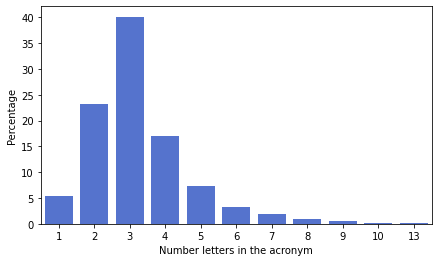

In [201]:
plt.figure(figsize=(7,4))
sns.barplot(x='Number letters in the acronym', y='Percentage', data=letters, color = 'royalblue')
plt.savefig("images/letters_train.png")
plt.show()

In [202]:
sf_lf_list = sf_lf.groupby('short_form', as_index=False).agg({'long_form': list})
sf_lf_list['len_definitions'] = sf_lf_list['long_form'].map(lambda x: len(x))
sf_lf_list.sort_values('len_definitions', ascending = False)

,short_form,long_form,len_definitions
48,AST,"[aspartate aminotransferase, aspartatoaminotransferasa, aspartate and alanine aminotransferase, ...",5
481,PCR,"[proteina c reactiva, polymerase chain reaction, reaccion cadena polimerasa, parada cardiorrespi...",4
573,TAC,"[tomografia axial computarizada, tomografia axial computerizada, tomografia axial computadorizad...",4
273,GGT,"[gammaglutamiltranspeptidasa, gamma glutamil transpeptidasa, gammaglutamil transpeptidasa, gama ...",4
238,FA,"[fluorescein angiography, fosfatasa alcalina, autofluorescencia fondo, fibrilacion auricular]",4
...,...,...,...
275,GLA,[galactosidasa],1
278,GRE,[gradientecho],1
279,GRP,[gastrostomia radiologica percutanea],1
280,Ga-67,[galio67],1


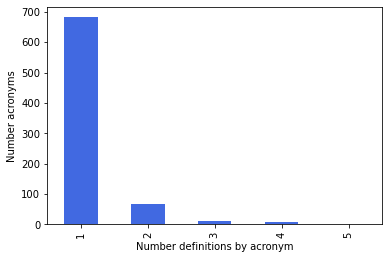

In [203]:
table = pd.crosstab(sf_lf_list['len_definitions'], columns = 'Count')
table.plot.bar(legend = None, color = 'royalblue')
plt.xlabel("Number definitions by acronym")
plt.ylabel("Number acronyms")
plt.savefig('images/definitions_count_train.png')
plt.show()

In [204]:
table = pd.crosstab(sf_lf_list['len_definitions'], columns = 'Count')
table.reset_index(inplace = True)
table = table.rename(columns = {'len_definitions':'Definitions by acronym'})
table

col_0,Definitions by acronym,Count
0,1,682
1,2,67
2,3,11
3,4,7
4,5,1


In [205]:
table = pd.crosstab(sf_lf_list['len_definitions'], columns = 'Count')
table.reset_index(inplace = True)
table['Percentage'] = table['Count'].map(lambda x: round((x/768)*100, 2))
table = table.rename(columns = {'len_definitions':'Definitions by acronym'})
table[['Definitions by acronym', 'Percentage']]

col_0,Definitions by acronym,Percentage
0,1,88.80
1,2,8.72
2,3,1.43
3,4,0.91
4,5,0.13


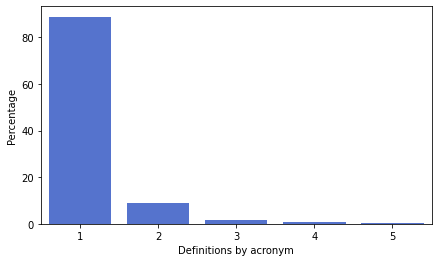

In [206]:
plt.figure(figsize=(7,4))
sns.barplot(x='Definitions by acronym', y='Percentage', data=table, color = 'royalblue')
plt.savefig("images/percentage_definitions_train.png")
plt.show()

In [207]:
train.head(3)

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908,1910
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684,1686
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656,1658


In [208]:
grup_doc = train.groupby('doc_id').agg({'short_form':'nunique'})
print('Mean', round(grup_doc.short_form.mean(),2))
print('Max', grup_doc.short_form.max())
print('Min', grup_doc.short_form.min())
print('Median', grup_doc.short_form.median())

Mean 8.04
Max 54
Min 1
Median 6.0


In [209]:
grup_sf = train.groupby('short_form').agg({'short_form':'count', 'long_form':'nunique', 'doc_id':'nunique'}).rename(columns = {'short_form': 'number_rows'}).reset_index()
grup_sf = grup_sf.rename(columns = {'long_form': 'Different definitions', 'doc_id':'Number documents'})
grup_sf['Percentage'] = grup_sf['number_rows'].map(lambda x: round((x/768)*100, 2))
grup_sf[['short_form','number_rows', 'Percentage', 'Different definitions','Number documents']].sort_values(by = 'number_rows', ascending = False).head(10)

,short_form,number_rows,Percentage,Different definitions,Number documents
715,mg,399,51.95,1,118
669,cm,217,28.26,2,110
678,dl,185,24.09,1,66
573,TAC,118,15.36,4,70
723,mm,114,14.84,2,69
700,l,110,14.32,1,38
462,OI,109,14.19,2,17
370,L,107,13.93,3,19
683,g,107,13.93,1,57
721,ml,106,13.80,1,53


#### Apply Levenshtein distance to normalize Long Forms

Get more frequent lf per sf

In [210]:
frec = train['long_form'].value_counts().reset_index()
frec

,index,long_form
0,miligramo,404
1,decilitro,289
2,centimetro,235
3,litro,215
4,mililitro,180
...,...,...
776,remision parcial buena,1
777,kilopascal,1
778,neutral protamine hagedorn,1
779,granulocytecolony stimulating factor,1


Create a dictionary where keys are the lf to normalize and the values the normalized form

In [211]:
norm = []
for i in sf_lf_list['long_form']:
    norm.append(normalize_lf(i))

In [212]:
norm = [i for i in norm if i != None]

In [213]:
norm_dict = {}
for i in norm:
    norm_dict.update(i)
#norm_dict

Finally normalize long forms over the dataframe

In [214]:
train.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908,1910
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684,1686
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656,1658
3,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1414,1416
12,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",g,gramo,1654,1655


In [215]:
train = train.replace({"long_form": norm_dict})

Check that deffinitions have been normalized

In [216]:
train.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908,1910
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684,1686
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656,1658
3,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1414,1416
12,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",g,gramo,1654,1655


### New statistics after normalize definitions

In [217]:
sf_lf = train[['short_form', 'long_form']].drop_duplicates()

In [218]:
sf_lf_list = sf_lf.groupby('short_form', as_index=False).agg({'long_form': list})
sf_lf_list['len_definitions'] = sf_lf_list['long_form'].map(lambda x: len(x))
sf_lf_list.sort_values('len_definitions', ascending = False)

,short_form,long_form,len_definitions
85,C,"[centimetro, centigrado, cysteine, peak c]",4
238,FA,"[fluorescein angiography, fosfatasa alcalina, autofluorescencia fondo, fibrilacion auricular]",4
481,PCR,"[proteina c reactiva, polymerase chain reaction, reaccion cadena polimerasa, parada cardiorrespi...",4
89,C4,"[cuarta vertebra cervical, cuarto componente complemento, componente 4]",3
31,ALT,"[alanine transaminase, alanine transferase, alanina aminotransferasa]",3
...,...,...,...
271,GER,[gasto energetico reposo],1
272,GFAP,[glial fibrilary acidic protein],1
274,GIST,[gastrointestinal stromal tumor],1
275,GLA,[galactosidasa],1


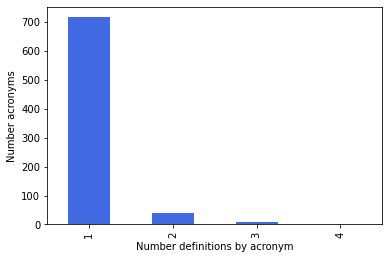

In [219]:
table = pd.crosstab(sf_lf_list['len_definitions'], columns = 'Count')
table.plot.bar(legend = None, color = 'royalblue')
plt.xlabel("Number definitions by acronym")
plt.ylabel("Number acronyms")
plt.savefig('images/definitions_count_train_normalize.png')
plt.show()

In [220]:
table = pd.crosstab(sf_lf_list['len_definitions'], columns = 'Count')
table.reset_index(inplace = True)
table = table.rename(columns = {'len_definitions':'Definitions by acronym'})
table

col_0,Definitions by acronym,Count
0,1,716
1,2,41
2,3,8
3,4,3


In [221]:
table = pd.crosstab(sf_lf_list['len_definitions'], columns = 'Count')
table.reset_index(inplace = True)
table['Percentage'] = table['Count'].map(lambda x: round((x/768)*100, 2))
table = table.rename(columns = {'len_definitions':'Definitions by acronym'})
table[['Definitions by acronym', 'Percentage']]

col_0,Definitions by acronym,Percentage
0,1,93.23
1,2,5.34
2,3,1.04
3,4,0.39


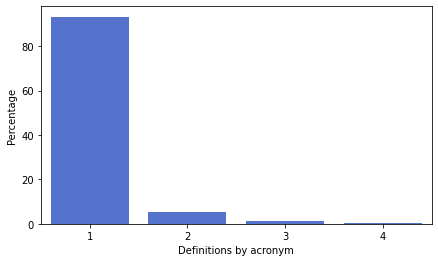

In [222]:
plt.figure(figsize=(7,4))
sns.barplot(x='Definitions by acronym', y='Percentage', data=table, color = 'royalblue')
plt.savefig("images/percentage_definitions_train_normalize.png")
plt.show()

In [223]:
train.head(3)

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908,1910
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684,1686
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656,1658


In [224]:
grup_doc = train.groupby('doc_id').agg({'short_form':'nunique'})
print('Mean', round(grup_doc.short_form.mean(),2))
print('Max', grup_doc.short_form.max())
print('Min', grup_doc.short_form.min())
print('Median', grup_doc.short_form.median())

Mean 8.04
Max 54
Min 1
Median 6.0


In [225]:
grup_sf = train.groupby('short_form').agg({'short_form':'count', 'long_form':'nunique', 'doc_id':'nunique'}).rename(columns = {'short_form': 'number_rows'}).reset_index()
grup_sf = grup_sf.rename(columns = {'long_form': 'Different definitions', 'doc_id':'Number documents'})
grup_sf['Percentage'] = grup_sf['number_rows'].map(lambda x: round((x/768)*100, 2))
grup_sf[['short_form','number_rows', 'Percentage', 'Different definitions','Number documents']].sort_values(by = 'number_rows', ascending = False).head(10)

,short_form,number_rows,Percentage,Different definitions,Number documents
715,mg,399,51.95,1,118
669,cm,217,28.26,2,110
678,dl,185,24.09,1,66
573,TAC,118,15.36,1,70
723,mm,114,14.84,2,69
700,l,110,14.32,1,38
462,OI,109,14.19,1,17
370,L,107,13.93,3,19
683,g,107,13.93,1,57
721,ml,106,13.80,1,53


In [226]:
#Top 10 de sólo aquellos acrónimos que son ambiguos
grup_sf = train.groupby('short_form').agg({'short_form':'count', 'long_form':'nunique', 'doc_id':'nunique'}).rename(columns = {'short_form': 'number_rows'}).reset_index()
grup_sf = grup_sf.rename(columns = {'long_form': 'Different definitions', 'doc_id':'Number documents'})
grup_sf['Percentage'] = grup_sf['number_rows'].map(lambda x: round((x/768)*100, 2))
grup_sf = grup_sf[grup_sf['Different definitions'] >1]
grup_sf[['short_form','number_rows', 'Percentage', 'Different definitions','Number documents']].sort_values(by = 'number_rows', ascending = False).head(10)

,short_form,number_rows,Percentage,Different definitions,Number documents
669,cm,217,28.26,2,110
723,mm,114,14.84,2,69
370,L,107,13.93,3,19
689,h,97,12.63,3,38
699,kg,89,11.59,2,36
614,U,80,10.42,2,21
85,C,49,6.38,4,30
481,PCR,40,5.21,4,19
238,FA,25,3.26,4,7
643,VSG,19,2.47,2,16


## Prepare Test Data

### Preprocessing

In [227]:
testing_raw.rename(columns={'nombre':'doc_id'}, inplace = True)

In [228]:
test = testing_raw.merge(testing_abbr[['doc_id', 'Abbreviation', 'Definition_lemmatized']], on = 'doc_id', how = 'left')

In [229]:
test = test.merge(testing_abbr, on = ['doc_id', 'Abbreviation'], how = 'left')

In [230]:
test = test.drop_duplicates()

In [231]:
test = test[['doc_id', 'texto', 'Abbreviation', 'Definition_lemmatized_x', 'StartOffset', 'EndOffset']]

In [232]:
test = test.rename(columns = {'Definition_lemmatized_x':'Definition'})

In [233]:
test.head()

,doc_id,texto,Abbreviation,Definition,StartOffset,EndOffset
0,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",PAI,pancreatitis autoinmunir,2502.0,2505.0
1,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",SLA,anti-soluble liver antiger,702.0,705.0
2,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",SMA,smooth muscle actin,697.0,700.0
3,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",LKM1,liver-kidney microsomal type 1,691.0,695.0
4,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",ANCA,antineutrophil cytoplasmic antibodie,685.0,689.0


In [234]:
test = test.rename(columns = {'Abbreviation': 'short_form', 'Definition': 'long_form'})

In [235]:
test = test.dropna(subset = ['short_form', 'long_form'])

In [236]:
test[['StartOffset', 'EndOffset']] = test[['StartOffset', 'EndOffset']].astype(int)

Clean long forms to delete acents, string punctuation etc

In [237]:
test['long_form'] = test['long_form'].map(clean_text)

In [252]:
test.head(3)

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",PAI,pancreatitis autoinmunir,2502,2505
1,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",SLA,antisoluble liver antiger,702,705
2,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",SMA,smooth muscle actin,697,700


In [253]:
test.short_form.nunique()

685

### Analysis acronyms and definitions

In [238]:
sf_lf = test[['short_form', 'long_form']].drop_duplicates()

In [241]:
#Number of short forms in train
sf_lf.short_form.nunique()

685

In [239]:
#Length of the abbreviations
sf_lf['len_sf'] = sf_lf['short_form'].map(lambda x: len(x))
letters = sf_lf['len_sf'].value_counts().rename_axis('Number letters in the acronym').reset_index(name='Count')
letters.Count = letters.Count.map (lambda x: round(x,2))
letters

,Number letters in the acronym,Count
0,3,281
1,2,197
2,4,140
3,5,48
4,1,48
5,6,30
6,7,18
7,8,12
8,9,3
9,11,1


In [242]:
#Length of the abbreviations
sf_lf['len_sf'] = sf_lf['short_form'].map(lambda x: len(x))
letters = sf_lf['len_sf'].value_counts(normalize = True).mul(100).rename_axis('Number letters in the acronym').reset_index(name='Percentage')
letters.Percentage = letters.Percentage.map (lambda x: round(x,2))
letters

,Number letters in the acronym,Percentage
0,3,36.03
1,2,25.26
2,4,17.95
3,5,6.15
4,1,6.15
5,6,3.85
6,7,2.31
7,8,1.54
8,9,0.38
9,11,0.13


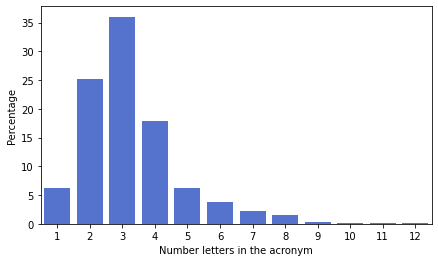

In [254]:
plt.figure(figsize=(7,4))
sns.barplot(x='Number letters in the acronym', y='Percentage', data=letters, color = 'royalblue')
plt.savefig("images/letters_test.png")
plt.show()

In [244]:
sf_lf_list = sf_lf.groupby('short_form', as_index=False).agg({'long_form': list})
sf_lf_list['len_definitions'] = sf_lf_list['long_form'].map(lambda x: len(x))
sf_lf_list.sort_values('len_definitions', ascending = False)

,short_form,long_form,len_definitions
87,C3,"[tercero componente complemento, tercero vertebra cervical, complemento 3, nivel c subnivel 3]",4
241,G,"[gauge, guanine, guanina]",3
215,F,"[filamentous, fenilalanina, french]",3
481,T,"[treonina, thymus, onda t]",3
416,PL,"[puncion lumbar, percepcion luz, periodo lavado]",3
...,...,...,...
252,GOT,[glutamic oxalic transaminar],1
253,GPL,[g fosfolipido],1
254,GPT,[glutamate pyruvatar transaminar],1
255,GQ-1b,[antigangliosidir antibodie 1b],1


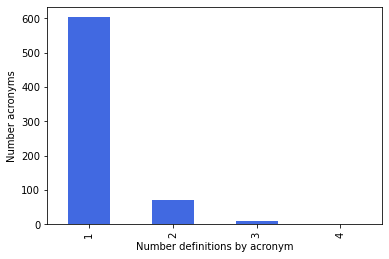

In [255]:
table = pd.crosstab(sf_lf_list['len_definitions'], columns = 'Count')
table.plot.bar(legend = None, color = 'royalblue')
plt.xlabel("Number definitions by acronym")
plt.ylabel("Number acronyms")
plt.savefig('images/definitions_count_test.png')
plt.show()

In [256]:
table = pd.crosstab(sf_lf_list['len_definitions'], columns = 'Count')
table.reset_index(inplace = True)
table = table.rename(columns = {'len_definitions':'Definitions by acronym'})
table

col_0,Definitions by acronym,Count
0,1,603
1,2,70
2,3,11
3,4,1


In [257]:
table = pd.crosstab(sf_lf_list['len_definitions'], columns = 'Count')
table.reset_index(inplace = True)
table['Percentage'] = table['Count'].map(lambda x: round((x/768)*100, 2))
table = table.rename(columns = {'len_definitions':'Definitions by acronym'})
table[['Definitions by acronym', 'Percentage']]

col_0,Definitions by acronym,Percentage
0,1,78.52
1,2,9.11
2,3,1.43
3,4,0.13


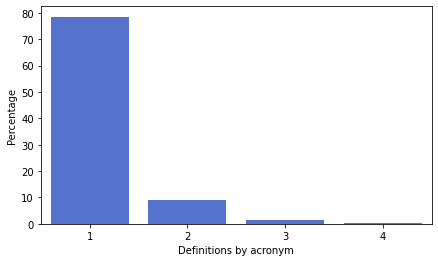

In [258]:
plt.figure(figsize=(7,4))
sns.barplot(x='Definitions by acronym', y='Percentage', data=table, color = 'royalblue')
plt.savefig("images/percentage_definitions_test.png")
plt.show()

In [277]:
grup_doc = test.groupby('doc_id').agg({'short_form':'nunique'})
print('Mean', round(grup_doc.short_form.mean(),2))
print('Max', grup_doc.short_form.max())
print('Min', grup_doc.short_form.min())
print('Median', grup_doc.short_form.median())

Mean 9.14
Max 45
Min 1
Median 7.0


In [278]:
grup_sf = test.groupby('short_form').agg({'short_form':'count', 'long_form':'nunique', 'doc_id':'nunique'}).rename(columns = {'short_form': 'number_rows'}).reset_index()
grup_sf = grup_sf.rename(columns = {'long_form': 'Different definitions', 'doc_id':'Number documents'})
grup_sf['Percentage'] = grup_sf['number_rows'].map(lambda x: round((x/768)*100, 2))
grup_sf[['short_form','number_rows', 'Percentage', 'Different definitions','Number documents']].sort_values(by = 'number_rows', ascending = False).head(10)

,short_form,number_rows,Percentage,Different definitions,Number documents
629,mg,360,46.88,2,86
597,dl,154,20.05,1,47
586,cm,147,19.14,1,79
635,ml,104,13.54,1,45
492,TAC,96,12.50,1,54
602,g,94,12.24,1,44
613,kg,70,9.11,1,31
605,h,68,8.85,1,28
614,l,68,8.85,1,25
319,L,60,7.81,2,18


In [279]:
grup_sf = test.groupby('short_form').agg({'short_form':'count', 'long_form':'nunique', 'doc_id':'nunique'}).rename(columns = {'short_form': 'number_rows'}).reset_index()
grup_sf = grup_sf.rename(columns = {'long_form': 'Different definitions', 'doc_id':'Number documents'})
grup_sf['Percentage'] = grup_sf['number_rows'].map(lambda x: round((x/768)*100, 2))
grup_sf = grup_sf[grup_sf['Different definitions'] > 1]
grup_sf[['short_form','number_rows', 'Percentage', 'Different definitions','Number documents']].sort_values(by = 'number_rows', ascending = False).head(10)

,short_form,number_rows,Percentage,Different definitions,Number documents
629,mg,360,46.88,2,86
319,L,60,7.81,2,18
53,AV,39,5.08,3,16
643,mmol,28,3.65,2,8
578,c,16,2.08,3,3
408,PCR,14,1.82,2,13
416,PL,13,1.69,3,4
241,G,12,1.56,2,5
536,V2,11,1.43,2,2
682,μg,11,1.43,2,3


#### Apply Levenshtein distance to normalize Long Forms

Get more frequent lf per sf

In [259]:
frec = test['long_form'].value_counts().reset_index()
frec

,index,long_form
0,miligramo,361
1,decilitro,213
2,centimetro,171
3,litro,128
4,mililitro,117
...,...,...
673,cluster of differentiation 99,1
674,red cell distributi width,1
675,plaqueta,1
676,pulsacion minuto,1


Create a dictionary where keys are the lf to normalize and the values the normalized form

In [262]:
sf_lf_test = test[['short_form', 'long_form']].drop_duplicates()

In [264]:
sf_lf_list_test = sf_lf_test.groupby('short_form', as_index=False).agg({'long_form': list})
sf_lf_list_test['len'] = sf_lf_list_test['long_form'].map(lambda x: len(x))

In [265]:
norm_test = []
for i in sf_lf_list_test['long_form']:
    norm_test.append(normalize_lf(i))

In [266]:
norm_test = [i for i in norm_test if i != None]

In [267]:
norm_dict_test = {}
for i in norm_test:
    norm_dict_test.update(i)
#norm_dict

Finally normalize long forms over the dataframe

In [268]:
test.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",PAI,pancreatitis autoinmunir,2502,2505
1,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",SLA,antisoluble liver antiger,702,705
2,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",SMA,smooth muscle actin,697,700
3,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",LKM1,liverkidney microsomal type 1,691,695
4,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",ANCA,antineutrophil cytoplasmic antibodie,685,689


In [269]:
test = test.replace({"long_form": norm_dict_test})

In [270]:
test.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",PAI,pancreatitis autoinmunir,2502,2505
1,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",SLA,antisoluble liver antiger,702,705
2,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",SMA,smooth muscle actin,697,700
3,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",LKM1,liverkidney microsomal type 1,691,695
4,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",ANCA,antineutrophil cytoplasmic antibodie,685,689


In [271]:
sf_lf = test[['short_form', 'long_form']].drop_duplicates()

In [272]:
sf_lf_list = sf_lf.groupby('short_form', as_index=False).agg({'long_form': list})
sf_lf_list['len_definitions'] = sf_lf_list['long_form'].map(lambda x: len(x))
sf_lf_list.sort_values('len_definitions', ascending = False)

,short_form,long_form,len_definitions
87,C3,"[tercero componente complemento, tercero vertebra cervical, complemento 3, nivel c subnivel 3]",4
481,T,"[treonina, thymus, onda t]",3
475,ST,"[segmento onda onda t, segmento st, segmento electrocardiograma onda t]",3
215,F,"[filamentous, fenilalanina, french]",3
53,AV,"[agudeza visual, arteriovenoso, auriculoventricular]",3
...,...,...,...
247,GGT,[gammaglutamil transpeptidasa],1
248,GH,[growth hormoner],1
249,GIST,[gastrointestinal stromal tumour],1
250,GN,[glomerulonefriti],1


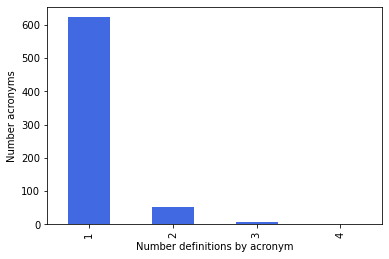

In [273]:
table = pd.crosstab(sf_lf_list['len_definitions'], columns = 'Count')
table.plot.bar(legend = None, color = 'royalblue')
plt.xlabel("Number definitions by acronym")
plt.ylabel("Number acronyms")
plt.savefig('images/definitions_count_test_normalize.png')
plt.show()

In [274]:
table = pd.crosstab(sf_lf_list['len_definitions'], columns = 'Count')
table.reset_index(inplace = True)
table = table.rename(columns = {'len_definitions':'Definitions by acronym'})
table

col_0,Definitions by acronym,Count
0,1,623
1,2,53
2,3,8
3,4,1


In [275]:
table = pd.crosstab(sf_lf_list['len_definitions'], columns = 'Count')
table.reset_index(inplace = True)
table['Percentage'] = table['Count'].map(lambda x: round((x/768)*100, 2))
table = table.rename(columns = {'len_definitions':'Definitions by acronym'})
table[['Definitions by acronym', 'Percentage']]

col_0,Definitions by acronym,Percentage
0,1,81.12
1,2,6.90
2,3,1.04
3,4,0.13


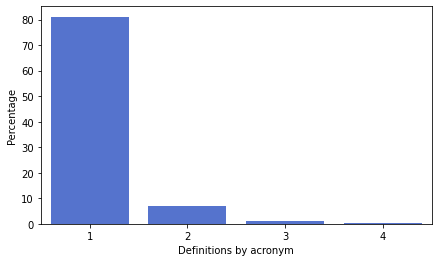

In [276]:
plt.figure(figsize=(7,4))
sns.barplot(x='Definitions by acronym', y='Percentage', data=table, color = 'royalblue')
plt.savefig("images/percentage_definitions_test_normalize.png")
plt.show()

## Analysis acronyms in test but not train

In [280]:
sf_train = train[['short_form']].drop_duplicates()

In [282]:
sf_test = test[['short_form']].drop_duplicates()

In [283]:
merged = sf_test.merge(sf_train, on = 'short_form', indicator = True, how = 'left')

In [284]:
merged.head()

,short_form,_merge
0,PAI,left_only
1,SLA,both
2,SMA,left_only
3,LKM1,left_only
4,ANCA,both


In [285]:
merged[merged['_merge'] == 'left_only'].shape

(395, 2)

In [287]:
merged[merged['_merge'] == 'left_only']['short_form'].unique().tolist()

['PAI',
 'SMA',
 'LKM1',
 'AMA-2',
 'CPRE',
 'USE',
 'EGD',
 'B2',
 'ADC',
 'MM',
 'XLRS',
 'R',
 'Q',
 'ERG',
 'IRM',
 'HPN',
 'cd10',
 'PKS',
 'IDMS',
 'MDRD',
 'mOsm',
 'R.N.',
 't1/2',
 'SIADH',
 'R.N',
 'P.A.A.F.',
 'dcha',
 'dcho',
 'EORTC',
 'ICRU',
 'BK',
 'A30',
 'A11',
 'B35',
 'B14',
 'DRX',
 'DR1',
 'ARA II',
 'GNMP',
 'GN',
 'P53',
 'CD56',
 'CD 117',
 'NWTS',
 'Cl.',
 'IECA',
 'Sm',
 'ds',
 'T4',
 'JO-1',
 'T3',
 'uU',
 'ASTO',
 'VES',
 'P.A.',
 'Eco',
 'GPL',
 'F.R.',
 'F.C.',
 'MPL',
 'UVI',
 'SAMUR',
 'AJCC',
 'PD',
 'LLC',
 'B27',
 'BAC',
 'NF',
 'MV',
 'MICS',
 'tA',
 'BLEE',
 'XL',
 'C.',
 'MROC',
 'MU',
 'TNM',
 'ECOG',
 'A.P.',
 'E3',
 'E1',
 'c-kit',
 'CD 56',
 'L2',
 'SSp',
 'anti-LA',
 'anti-Ro',
 'C1q',
 'AINE',
 'IFd',
 'HPA-1a',
 'IGIV',
 'TFNA',
 'PAAFs',
 'MEN',
 'AINEs',
 'SERMS',
 'A.I.N.E.',
 'HELLP',
 'cm3',
 'L.',
 'EDA',
 'DMAE',
 'PL',
 'r-TPA',
 'MNV',
 'Ki-67',
 'N.',
 'CID',
 'CA19-9',
 'CA 15-3',
 'CA 125',
 'anti-Yo',
 'DCP',
 'T11',
 'DQ2',
 '

In [289]:
train[train['short_form']=='EGD']

,doc_id,texto,short_form,long_form,StartOffset,EndOffset


In [290]:
sf_only_test = merged[merged['_merge'] == 'left_only']
sf_only_test.head()

,short_form,_merge
0,PAI,left_only
2,SMA,left_only
3,LKM1,left_only
5,AMA-2,left_only
11,CPRE,left_only


In [292]:
test2 = test[['short_form', 'long_form']]

In [294]:
merged_sf_only_test = sf_only_test[['short_form']].merge(test2, on = 'short_form', how = 'left')

In [295]:
merged_sf_only_test.head()

,short_form,long_form
0,PAI,pancreatitis autoinmunir
1,SMA,smooth muscle actin
2,LKM1,liverkidney microsomal type 1
3,AMA-2,antimitochondrial2 antibody
4,CPRE,colangiopancreatografia retrogrado endoscopico


In [296]:
sf_lf_only = merged_sf_only_test[['short_form', 'long_form']].drop_duplicates()

In [297]:
#Length of the abbreviations
sf_lf_only['len_sf'] = sf_lf_only['short_form'].map(lambda x: len(x))
letters = sf_lf_only['len_sf'].value_counts().rename_axis('Number letters in the acronym').reset_index(name='Count')
letters.Count = letters.Count.map (lambda x: round(x,2))
letters

,Number letters in the acronym,Count
0,3,141
1,4,92
2,2,78
3,5,39
4,6,25
5,7,17
6,8,11
7,1,7
8,9,3
9,11,1


In [298]:
sf_lf_list = sf_lf_only.groupby('short_form', as_index=False).agg({'long_form': list})
sf_lf_list['len_definitions'] = sf_lf_list['long_form'].map(lambda x: len(x))
sf_lf_list.sort_values('len_definitions', ascending = False)

,short_form,long_form,len_definitions
175,I,"[isoleucina, izquierdo, yodo]",3
256,PL,"[puncion lumbar, percepcion luz, periodo lavado]",3
53,C.,"[citrobacter, chlamydia]",2
158,HB,"[hemoglobina, hepatitis b]",2
77,CHOP,"[ciclofosfamido hidroxidaunomicina oncovin prednisono, cyclophosphamidir hydroxydaunomycin oncov...",2
...,...,...,...
132,ETE,[ecocardiografia transesofagico],1
131,ERG,[electrorretinograma],1
130,ERC,[enfermedad renal cronica],1
129,ERA,[epitelitis retiniana agudo],1


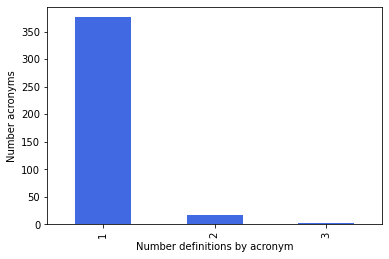

In [299]:
table = pd.crosstab(sf_lf_list['len_definitions'], columns = 'Count')
table.plot.bar(legend = None, color = 'royalblue')
plt.xlabel("Number definitions by acronym")
plt.ylabel("Number acronyms")
plt.savefig('images/definitions_count_only_test.png')
plt.show()

In [300]:
table = pd.crosstab(sf_lf_list['len_definitions'], columns = 'Count')
table.reset_index(inplace = True)
table = table.rename(columns = {'len_definitions':'Definitions by acronym'})
table

col_0,Definitions by acronym,Count
0,1,376
1,2,17
2,3,2


In [301]:
table = pd.crosstab(sf_lf_list['len_definitions'], columns = 'Count')
table.reset_index(inplace = True)
table['Percentage'] = table['Count'].map(lambda x: round((x/768)*100, 2))
table = table.rename(columns = {'len_definitions':'Definitions by acronym'})
table[['Definitions by acronym', 'Percentage']]

col_0,Definitions by acronym,Percentage
0,1,48.96
1,2,2.21
2,3,0.26


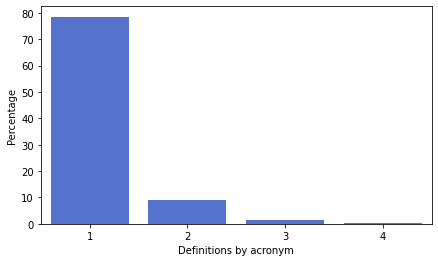

In [258]:
plt.figure(figsize=(7,4))
sns.barplot(x='Definitions by acronym', y='Percentage', data=table, color = 'royalblue')
plt.savefig("images/percentage_definitions_test.png")
plt.show()

In [277]:
grup_doc = test.groupby('doc_id').agg({'short_form':'nunique'})
print('Mean', round(grup_doc.short_form.mean(),2))
print('Max', grup_doc.short_form.max())
print('Min', grup_doc.short_form.min())
print('Median', grup_doc.short_form.median())

Mean 9.14
Max 45
Min 1
Median 7.0


## Dictionary from ABREMES-DB

In [4]:
sf_lf = pd.read_csv("AbreMES-DB/DB/pairs.tsv", sep = '\t')

In [6]:
sf_lf.head(2)

,# Pair ID,Abbreviation ID,Definition ID,Frequency,Abbreviation,Definition,Appears on
0,1,3348,17876,31,DDD,diaria definida,"http://www.scielo.edu.uy/scielo.php?script=sci_arttext&pid=S1688-03902003000300004,http://scielo..."
1,2,11880,23106,11,HP-CHPR,Hospital Pediátrico del Centro Hospitalario Pereira Rossell,"http://www.scielo.edu.uy/scielo.php?script=sci_arttext&pid=S1688-03902003000300004,http://www.sc..."


In [7]:
sf_lf.Abbreviation.nunique()

21146

In [8]:
sf_lf.Definition.nunique()

49691

In [9]:
df2 = sf_lf.groupby(['Abbreviation','Definition']).size().reset_index()

In [10]:
df2.shape

(52494, 3)

In [11]:
df2.drop_duplicates().shape

(52494, 3)

In [12]:
df3 = sf_lf.groupby(['Abbreviation']).agg({'Definition':'nunique'}).reset_index()

In [13]:
df3.head()

,Abbreviation,Definition
0,1 -MCP,1
1,1 m²,1
2,"1,3-PD",1
3,1-149 meses,1
4,1-MCP,3


In [15]:
df3[df3.Definition > 1]['Abbreviation'].nunique()

6754

In [16]:
df3[df3.Definition > 1].head()

,Abbreviation,Definition
4,1-MCP,3
26,18F-FDG,8
28,18FDG,3
30,18 OBF,2
36,"2,4-D",2


In [17]:
df4 = sf_lf.groupby(['Abbreviation']).agg({'Definition':'unique'}).reset_index()

In [18]:
df4['numdefs'] = df4.apply(lambda x: len(x['Definition']),axis = 1)

In [20]:
df4[df4.numdefs > 1].head(10)

,Abbreviation,Definition,numdefs
4,1-MCP,"[1-metilciclopropeno, 1-Metilciclopropeno, 1-Metilciclopropano]",3
26,18F-FDG,"[18F-fluorodeoxyglucose, 18 flúor-fluorodeoxiglucosa, 18F- fluordeoxiglucosa, 18F-fluorodesoxigl...",8
28,18FDG,"[18F-fluoro-2-desoxi-D-glucosa, 18F-fluoro-2-deoxi- d -glucosa, 18F-flúor-2-deoxi-D-glucosa]",3
30,18 OBF,"[18va Olimpiada Boliviana de F&#305;sica, 18va Olimpiada Boliviana de Física]",2
36,"2,4-D","[2,4-diclorofenoxiacético, 2,4-Diclorofenoxiácetico]",2
48,25OHD,"[25-OH vitamina D, 25(OH) vitamina D]",2
81,5-FU,"[5-fluorouracilo, 5-Fluorouracilo, 5fluorouracilo, 5-fluor-uracilo, 5-fluouracilo, 5-fluorounacilo]",6
110,99mTc-HMPAO,"[99mTc-hexametil-propilen-amino oxima, 99mTc-Tecnecio hexametilpropilenoamina oxima]",2
111,99mTc-MIBI,"[99mTc-metoxi-isobutyl-isonitrilo, 99mTc-metoxi-isobutil-isonitrilo]",2
120,A+,"[excitatorios, consecuencia, afectuosas, afectuosos, autolesiones con, social: 5,6]",6


## Analysis Soto output and number fo defs